<a href="https://colab.research.google.com/github/Andreas-Lukito/Medzy_ocr/blob/main/medzy_hyperopt_colab_ver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medzy

## Overview

This project aims to develop a machine learning model capable of interpreting doctors’ handwriting on prescriptions. By accurately detecting and translating challenging handwriting, the model will empower patients to read their prescriptions independently, making it easier for them to purchase their medications without confusion if they run out of medecine or to check if the cleric gave the correct medicine.

This model will use Tensor flows' keras convolutional neural network as reference to this <a href = "https://www.tensorflow.org/tutorials/images/cnn">documentation</a>. The model will also be trained using this <a href="https://www.kaggle.com/datasets/mamun1113/doctors-handwritten-prescription-bd-dataset">dataset</a> from kaggle.

## Importing needed libraries

In [1]:
!pip install hyperopt
!pip install pynvml

In [2]:
# basic python libraries
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageFilter
import cv2
import numpy as np
import os
import glob

# data preprocessing libraries
from sklearn.preprocessing import LabelEncoder

# tensor flow libraries
import tensorflow as tf
import keras
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Fine tuning libraries
import hyperopt
from hyperopt import hp, fmin, tpe, Trials, space_eval, STATUS_OK

# library for gpu utilization
import pynvml

## GPU check

In [3]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Check if TensorFlow is using the GPU
if tf.test.is_gpu_available():
    print("TensorFlow is using the GPU")

    # Initialize the pynvml library
    pynvml.nvmlInit()

    # Get the number of GPU devices
    num_gpus = pynvml.nvmlDeviceGetCount()

    # Iterate over GPU devices
    for i in range(num_gpus):
        # Get the device identifier
        handle = pynvml.nvmlDeviceGetHandleByIndex(i)
        # Get the full GPU name
        gpu_name = pynvml.nvmlDeviceGetName(handle)
        print("GPU Name:", gpu_name)

    # Shutdown the pynvml library
    pynvml.nvmlShutdown()
else:
    print("TensorFlow is not using the GPU")

TensorFlow is using the GPU
GPU Name: b'NVIDIA A100-SXM4-40GB'


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Importing the Data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Train data

#### Train Labels

In [6]:
train_path = "/content/drive/MyDrive/project_medzy/dataset/Training"
train_labels = pd.read_csv(os.path.join(train_path,"training_labels.csv"), delimiter = ",")

In [7]:
train_labels.head()

,IMAGE,MEDICINE_NAME,GENERIC_NAME
0,0.png,Aceta,Paracetamol
1,1.png,Aceta,Paracetamol
2,2.png,Aceta,Paracetamol
3,3.png,Aceta,Paracetamol
4,4.png,Aceta,Paracetamol


##### Encode the medecine name

In [8]:
medicine_enc = LabelEncoder()
train_name_enc = to_categorical(medicine_enc.fit_transform(train_labels["MEDICINE_NAME"]), num_classes=78)
# train_labels["MEDICINE_NAME_ENC"] = train_name_enc

In [9]:
len(train_labels["MEDICINE_NAME"].unique())

78

after encoding there are 78 unique values/medicines since we are using label encoder, we will put them all in to a seperate column

#### Train Images

In [10]:
#the image width and height to pass to the model
img_width = 420
img_height = np.round(img_width/3, 0).astype("int")

In [11]:
train_images = []
train_files = glob.glob("/content/drive/MyDrive/project_medzy/dataset/Training/training_words/*.png")
for picture in train_files:
    image = cv2.resize(cv2.imread(picture), (img_width, img_height))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #since cv2 sometimes return a "none" type we will append the data after validating it if it is a not "none" type
    if image is None:
        print(f"Err importing picture {picture}")
        continue

    #apply adaptive treshold
    image = cv2.adaptiveThreshold(image,
                                         255, # the max value
                                         cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                         cv2.THRESH_BINARY, #the treshold we are using
                                         41, #how many pixels to look at
                                         10 #noise reduction
                                         )

    #sharpening the image
    # Create the sharpening kernel
    kernel = np.array([[-1, -1, 1],
                        [-1,  8, -1],
                        [-1, -2, -1]])

    #increase the contrast
    clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(7,7))
    image = clahe.apply(image)

    #blur the image so that the lines are more defined
    image = cv2.GaussianBlur(image, (7,7), 20)
    image = cv2.GaussianBlur(image, (7,7), 20)
    image = cv2.GaussianBlur(image, (7,7), 20)

    # Sharpen the image
    image = cv2.filter2D(image, -1, kernel)

    train_images.append(image)

    # image = np.asarray(image) # for numpy 1.23
    # To show the images
    # plt.imshow(image, cmap = "gray")
    # plt.show()

train_images = np.array(train_images)
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

# Shuffling the data
BUFFER_SIZE = len(train_images)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)

In [12]:
print("Dataset shape:", train_images[0].shape)
print("Labels shape:", train_labels.shape)

Dataset shape: (140, 420)
Labels shape: (3120, 3)


##### Check if it is correct

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
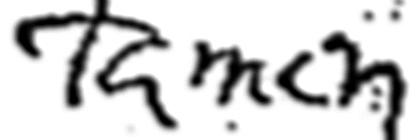

In [13]:
train_images[0]

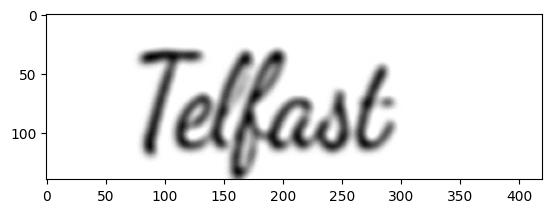

In [14]:
plt.imshow(train_images[20], cmap = "gray")

In [15]:
print("Example label:", train_labels.iloc[3])

Example label: IMAGE                  3.png
MEDICINE_NAME          Aceta
GENERIC_NAME     Paracetamol
Name: 3, dtype: object


### Validation data

#### validation Labels

In [16]:
validation_path = "/content/drive/MyDrive/project_medzy/dataset/Validation"
validation_labels = pd.read_csv(os.path.join(validation_path,"validation_labels.csv"), delimiter = ",")

In [17]:
validation_labels.head()

,IMAGE,MEDICINE_NAME,GENERIC_NAME
0,0.png,Aceta,Paracetamol
1,1.png,Aceta,Paracetamol
2,2.png,Aceta,Paracetamol
3,3.png,Aceta,Paracetamol
4,4.png,Aceta,Paracetamol


##### Encode the medecine name

In [18]:
validation_name_enc = to_categorical(medicine_enc.transform(validation_labels["MEDICINE_NAME"]), num_classes=78)
# validation_labels["MEDECINE_NAME_ENC"] = validation_name_enc

In [19]:
type(validation_name_enc)

numpy.ndarray

In [20]:
len(validation_labels["MEDICINE_NAME"].unique())

78

#### Validation Images

In [21]:
validation_images = []
validation_files = glob.glob("/content/drive/MyDrive/project_medzy/dataset/Validation/validation_words/*.png")
for picture in validation_files:
    image = cv2.resize(cv2.imread(picture, cv2.IMREAD_GRAYSCALE), (img_width, img_height))

    #since cv2 sometimes return a "none" type we will append the data after validating it if it is a not "none" type
    if image is None:
        print(f"Err importing picture {picture}")
        continue
    #apply adaptive treshold
    image = cv2.adaptiveThreshold(image,
                                         255, # the max value
                                         cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                         cv2.THRESH_BINARY, #the treshold we are using
                                         41, #how many pixels to look at
                                         10 #noise reduction
                                         )

    #sharpening the image
    # Create the sharpening kernel
    kernel = np.array([[-1, -1, 1],
                        [-1,  8, -1],
                        [-1, -2, -1]])

    #increase the contrast
    clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(7,7))
    image = clahe.apply(image)

    #blur the image so that the lines are more defined
    image = cv2.GaussianBlur(image, (7,7), 20)
    image = cv2.GaussianBlur(image, (7,7), 20)
    image = cv2.GaussianBlur(image, (7,7), 20)

    # Sharpen the image
    image = cv2.filter2D(image, -1, kernel)


    validation_images.append(image)
    # image = np.asarray(image) # for numpy 1.23

    # To show the images
    # plt.imshow(image, cmap = "gray")
    # plt.show()

validation_images = np.array(validation_images)
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

# Shuffling the data
BUFFER_SIZE = len(validation_images)
validation_dataset = validation_dataset.shuffle(BUFFER_SIZE)

In [22]:
print("Dataset shape:", validation_images.shape)
print("Labels shape:", validation_labels.shape)

Dataset shape: (780, 140, 420)
Labels shape: (780, 3)


##### Check if it is correct

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
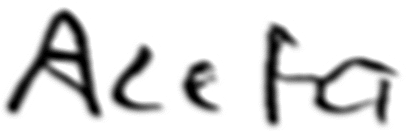

In [23]:
validation_images[0]

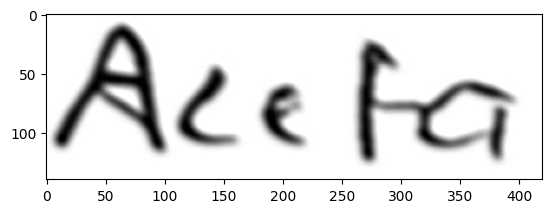

In [24]:
plt.imshow(validation_images[0], cmap = "gray")

In [25]:
print("Example label:", validation_labels.iloc[0])

Example label: IMAGE                  0.png
MEDICINE_NAME          Aceta
GENERIC_NAME     Paracetamol
Name: 0, dtype: object


### Test data

#### Test Labels

In [26]:
test_path = "/content/drive/MyDrive/project_medzy/dataset/Testing"
test_labels = pd.read_csv(os.path.join(test_path,"testing_labels.csv"), delimiter = ",")

In [27]:
test_labels.head()

,IMAGE,MEDICINE_NAME,GENERIC_NAME
0,0.png,Aceta,Paracetamol
1,1.png,Aceta,Paracetamol
2,2.png,Aceta,Paracetamol
3,3.png,Aceta,Paracetamol
4,4.png,Aceta,Paracetamol


##### Encode the medecine name

In [28]:
test_name_enc = to_categorical(medicine_enc.transform(test_labels["MEDICINE_NAME"]), num_classes=78)
# test_labels["train_medecine_name_enc"] = test_name_enc

In [29]:
len(test_labels["MEDICINE_NAME"].unique())

78

#### Testing Images

In [30]:
test_images = []
test_files = glob.glob("/content/drive/MyDrive/project_medzy/dataset/Testing/testing_words/*.png")
for picture in test_files:
    image = cv2.resize(cv2.imread(picture, cv2.IMREAD_GRAYSCALE), (img_width, img_height))

    #since cv2 sometimes return a "none" type we will append the data after validating it if it is a not "none" type
    if image is None:
        print(f"Err importing picture {picture}")
        continue
    #apply adaptive treshold
    image = cv2.adaptiveThreshold(image,
                                         255, # the max value
                                         cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                         cv2.THRESH_BINARY, #the treshold we are using
                                         41, #how many pixels to look at
                                         10 #noise reduction
                                         )

    #sharpening the image
    # Create the sharpening kernel
    kernel = np.array([[-1, -1, 1],
                        [-1,  8, -1],
                        [-1, -2, -1]])

    #increase the contrast
    clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(7,7))
    image = clahe.apply(image)

    #blur the image so that the lines are more defined
    image = cv2.GaussianBlur(image, (7,7), 20)
    image = cv2.GaussianBlur(image, (7,7), 20)
    image = cv2.GaussianBlur(image, (7,7), 20)

    # Sharpen the image
    image = cv2.filter2D(image, -1, kernel)

    test_images.append(image)
    # image = np.asarray(image) # for numpy 1.23

    # To show the images
    # plt.imshow(image, cmap = "gray")
    # plt.show()

test_images = np.array(test_images)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# Shuffling the data
BUFFER_SIZE = len(test_images)
test_dataset = test_dataset.shuffle(BUFFER_SIZE)

In [31]:
print("Dataset shape:", test_images.shape)
print("Labels shape:", test_labels.shape)

Dataset shape: (780, 140, 420)
Labels shape: (780, 3)


##### Check if it is correct

In [32]:
test_images[0].shape

(140, 420)

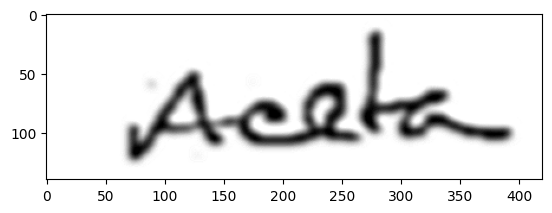

In [33]:
plt.imshow(test_images[0], cmap = "gray")

In [34]:
print("Example label:", test_labels.iloc[0])

Example label: IMAGE                  0.png
MEDICINE_NAME          Aceta
GENERIC_NAME     Paracetamol
Name: 0, dtype: object


## Building the artificial neural network

#### Make a model create function

##### Parameters for the model

In [35]:
#number of classes to determine how many neurons are in the output layer
num_classes = len(train_labels["MEDICINE_NAME"].unique())
num_classes

78

In [36]:
#the image size to determine the shape for the convolutional neural network to scan
train_images[0].shape

(140, 420)

#### Custom metric

In [37]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return keras.backend.cast(recall, "float16")

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return keras.backend.cast(precision, "float16")

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    f1 = 2*((precision*recall)/(precision+recall+K.epsilon()))
    return keras.backend.cast(f1, "float16")

#### Create a model builder for gridsearch

the even filter shapes aren't recommended because it lacks the ability to devide the previous layer pixels arould the output pixel <a hre = "https://medium.com/analytics-vidhya/how-to-choose-the-size-of-the-convolution-filter-or-kernel-size-for-cnn-86a55a1e2d15">(Pandey, 2020)</a>.

<a href = "https://medium.com/@nerdjock/convolutional-neural-network-lesson-9-activation-functions-in-cnns-57def9c6e759">Machine Learning in Plain English (2023)</a> The most common activation functions are "relu" and "leaky relu" therefore we would pass it in the grid search.

Max pooling excells in image classification, due to how max pooling captures the most prominent features and reduce the variance of the input <a href = "https://www.linkedin.com/advice/1/how-do-you-choose-appropriate-pooling-method-2uvmc#adaptive-pooling">(Awad et. al, n.d.)</a>.

In [38]:
# Model Parameters to Grid Search
params_space = {
    "filter_choice" : hp.choice("filter_choice", [32, 64, 128]),
    "kernel_size" : hp.choice("kernel_size", [3, 5, 7]),
    "n_neurons" : hp.choice("n_neurons", [128, 256, 512]),
    "learning_rate": hp.uniform("learning_rate",0.001,1),
    "activation" : hp.choice("activation",['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
                   'elu', 'exponential', 'softmax']),
    "n_conv_layers": hp.choice("n_conv_layers", [1, 3]),
    "n_pool_layers": hp.choice("n_pool_layers", [1, 2, 3]),
    "dense_optimizer": hp.choice('optimizer', ['adam', 'sgd', 'rmsprop']),
    "dropout_rate": hp.uniform("dropout_rate", 0.1, 0.5)
}

In [39]:
def create_model(params):
    input_shape = (img_height, img_width, 1)
    model = Sequential()
    metrics = ['accuracy', recall_m, precision_m]

    # Input layer
    model.add(layers.Conv2D(
        filters = params["filter_choice"],
        kernel_size = params["kernel_size"],
        activation= params["activation"],
        input_shape=input_shape
    ))
    model.add(layers.AveragePooling2D(pool_size=2))

    # Convolutional layers
    for i in range(params["n_conv_layers"]):
        model.add(layers.Conv2D(
            filters= params["filter_choice"],
            kernel_size = params["kernel_size"],
            activation= params["activation"]
        ))
        if i < params["n_pool_layers"]:
          model.add(layers.AveragePooling2D(pool_size=2))

    # drop out layers to prevent overfitting
    model.add(layers.Dropout(params['dropout_rate']))

    # Flatten layer
    model.add(layers.Flatten())

    # Intermediate dense layer
    model.add(layers.Dense(
        params["n_neurons"],
        activation= params["activation"]
    ))

    # another drop out layers to prevent overfitting
    model.add(layers.Dropout(params['dropout_rate']))

    # Output layer (78 classes)
    model.add(layers.Dense(78, activation="softmax"))

    # Optimizer selection
    optimizer_name = params["dense_optimizer"]
    if optimizer_name == 'adam': #dynamic learning rate
        optimizer = tf.keras.optimizers.Adam(learning_rate = params["learning_rate"])
    elif optimizer_name == 'sgd': #static learning rate
        optimizer = tf.keras.optimizers.SGD(learning_rate = params["learning_rate"])
    else:
        optimizer = tf.keras.optimizers.RMSprop(learning_rate = params["learning_rate"])

    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics = metrics)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      mode = 'min', #to match the fmin function from hyperopt
                                                                    #we will search for the model with the least loss
                                                      verbose=1,
                                                      patience=3)

    model.fit(train_images, train_name_enc,
              validation_data=(validation_images, validation_name_enc),
              callbacks=[early_stopping])

    loss, accuracy, recall, precision = model.evaluate(validation_images, validation_name_enc)
    print(f"validation Accuracy: {accuracy}")
    print(f"validation recall: {recall}")
    print(f"validation precision: {precision}")
    return {
        'loss' : loss,
        'status' :STATUS_OK,
        'model' : model,
        'params' : params
    }

In this project, a hyperopt gridsearch will be implemented as reference to <a href = "https://medium.com/@icaro_vazquez/neural-network-hyperparameter-optimization-with-hyperopt-f3e0cb4346c8">(Icaro, 2024)</a>.

In [40]:
# initialize trials to keep the history of every trial
trial =  Trials()

#### Start the grid search

In [41]:
best_params = fmin(
    fn = create_model,
    space = params_space,
    algo = tpe.suggest, #bayesian optimization
    max_evals= 200, #number of models to try
    trials= trial,
    batch_size =32,
)

  0%|          | 0/200 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



 1/98 ━━━━━━━━━━━━━━━━━━━━ 12:45 8s/step - accuracy: 0.0000e+00 - loss: 4.4601 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
 8/98 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0072 - loss: 21.6656 - precision_m: 5.0403e-04 - recall_m: 4.8828e-04     
15/98 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0065 - loss: 37.5180 - precision_m: 0.0017 - recall_m: 0.0017        
23/98 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0065 - loss: 49.3550 - precision_m: 0.0028 - recall_m: 0.0028
31/98 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0065 - loss: 58.2434 - precision_m: 0.0035 - recall_m: 0.0034
38/98 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0065 - loss: 63.6116 - precision_m: 0.0039 - recall_m: 0.0038
46/98 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0065 - loss: 67.5825 - precision_m: 0.0043 - recall_m: 0.0042
54/98 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0064 - loss: 70.0122 - precision_m: 0.0045 - recall_m: 0.0044
62/98 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accur

ERROR:hyperopt.fmin:job exception: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.

 40%|████      | 81/200 [14:43<21:38, 10.91s/trial, best loss: 4.3567118644714355]


ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-41-49e25ec3cf03>", line 1, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/hyperopt/fmin.py", line 540, in fmin

  File "/usr/local/lib/python3.11/dist-packages/hyperopt/base.py", line 671, in fmin

  File "/usr/local/lib/python3.11/dist-packages/hyperopt/fmin.py", line 586, in fmin

  File "/usr/local/lib/python3.11/dist-packages/hyperopt/fmin.py", line 364, in exhaust

  File "/usr/local/lib/python3.11/dist-packages/hyperopt/fmin.py", line 300, in run

  File "/usr/local/lib/python3.11/dist-packages/hyperopt/fmin.py", line 178, in serial_evaluate

  File "/usr/local/lib/python3.11/dist-packages/hyperopt/base.py", line 892, in evaluate

  File "<ipython-input-39-2873d6883313>", line 60, in create_model

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

Out of memory while trying to allocate 1544345752 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_284430]

Currently the best model is not performing well so it is best to change model and use a pretriained one

In [ ]:
space_eval(params_space, best_params)